In [11]:
import torch
import torchvision.models as models
import time
from torch.nn.utils import prune
import numpy
from matplotlib import pyplot as plt

In [12]:
all_models = [models.mobilenet_v3_large(), models.alexnet()]

In [13]:
device = None
if torch.backends.mps.is_available():
    print("MPS is available")
    device = 'mps'
else:
    print("MPS is not available")
    device = 'cpu'

MPS is available


In [14]:
def find_comp_time(model, device):
    model.to(device)
    model.eval()
    random_images = torch.randn(100, 3, 224, 224).to(device)
    avg_time = 0.0
    for _ in range(10):
        with torch.no_grad():
            t1 = time.time()
            _ = model(random_images)
            t2 = time.time()
            avg_time += (t2 - t1)
    avg_time /= 10
    return avg_time


In [15]:
pruning_rates = list(numpy.arange(0.0, 1.1, 0.1))
computation_time = {}

In [16]:
def prune_model(model, rate):
    for _, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=rate)
    return model

In [17]:
for model_org in all_models:
    print(f"-------------Model: {model_org.__class__.__name__}-------------")
    for rate in pruning_rates:
        model = model_org
        model = prune_model(model, rate)
        model = model.to(device)
        comp_time = find_comp_time(model, device)
        print(f"Model: {model_org.__class__.__name__}, Pruning rate: {rate:.2f}, Computation time: {comp_time:.5f} using {device}")
        if model_org.__class__.__name__ not in computation_time:
            computation_time[model_org.__class__.__name__] = []
        computation_time[model_org.__class__.__name__].append(comp_time)

-------------Model: MobileNetV3-------------
Model: MobileNetV3, Pruning rate: 0.00, Computation time: 0.14342 using mps
Model: MobileNetV3, Pruning rate: 0.10, Computation time: 0.05673 using mps
Model: MobileNetV3, Pruning rate: 0.20, Computation time: 0.05388 using mps
Model: MobileNetV3, Pruning rate: 0.30, Computation time: 0.05411 using mps
Model: MobileNetV3, Pruning rate: 0.40, Computation time: 0.05380 using mps
Model: MobileNetV3, Pruning rate: 0.50, Computation time: 0.05381 using mps
Model: MobileNetV3, Pruning rate: 0.60, Computation time: 0.05390 using mps
Model: MobileNetV3, Pruning rate: 0.70, Computation time: 0.05372 using mps
Model: MobileNetV3, Pruning rate: 0.80, Computation time: 0.05390 using mps
Model: MobileNetV3, Pruning rate: 0.90, Computation time: 0.05376 using mps
Model: MobileNetV3, Pruning rate: 1.00, Computation time: 0.05378 using mps
-------------Model: AlexNet-------------
Model: AlexNet, Pruning rate: 0.00, Computation time: 0.00179 using mps
Model:

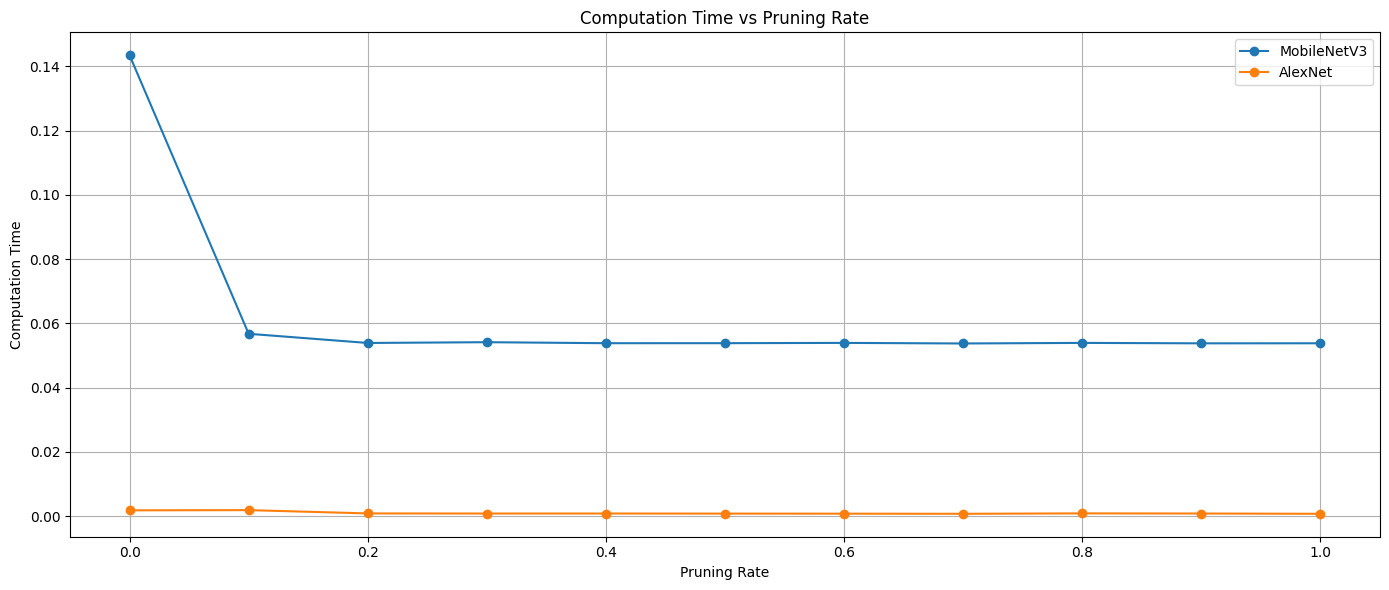

In [18]:
plt.figure(figsize=(14, 6))
for model_name in computation_time.keys():
    plt.plot(pruning_rates, computation_time[model_name], label=model_name, marker='o')
plt.xlabel('Pruning Rate')
plt.ylabel('Computation Time')
plt.grid(True)
plt.title('Computation Time vs Pruning Rate')
plt.tight_layout()
plt.legend()
plt.show()

Model: VGG, Pruning rate: 0.00, Computation time: 0.18147 using mps
Model: VGG, Pruning rate: 0.10, Computation time: 0.17606 using mps
Model: VGG, Pruning rate: 0.20, Computation time: 0.17677 using mps
Model: VGG, Pruning rate: 0.30, Computation time: 0.17610 using mps
Model: VGG, Pruning rate: 0.40, Computation time: 0.17559 using mps
Model: VGG, Pruning rate: 0.50, Computation time: 0.17578 using mps
Model: VGG, Pruning rate: 0.60, Computation time: 0.17745 using mps
Model: VGG, Pruning rate: 0.70, Computation time: 0.17782 using mps
Model: VGG, Pruning rate: 0.80, Computation time: 0.17690 using mps
Model: VGG, Pruning rate: 0.90, Computation time: 0.17921 using mps
Model: VGG, Pruning rate: 1.00, Computation time: 0.18134 using mps


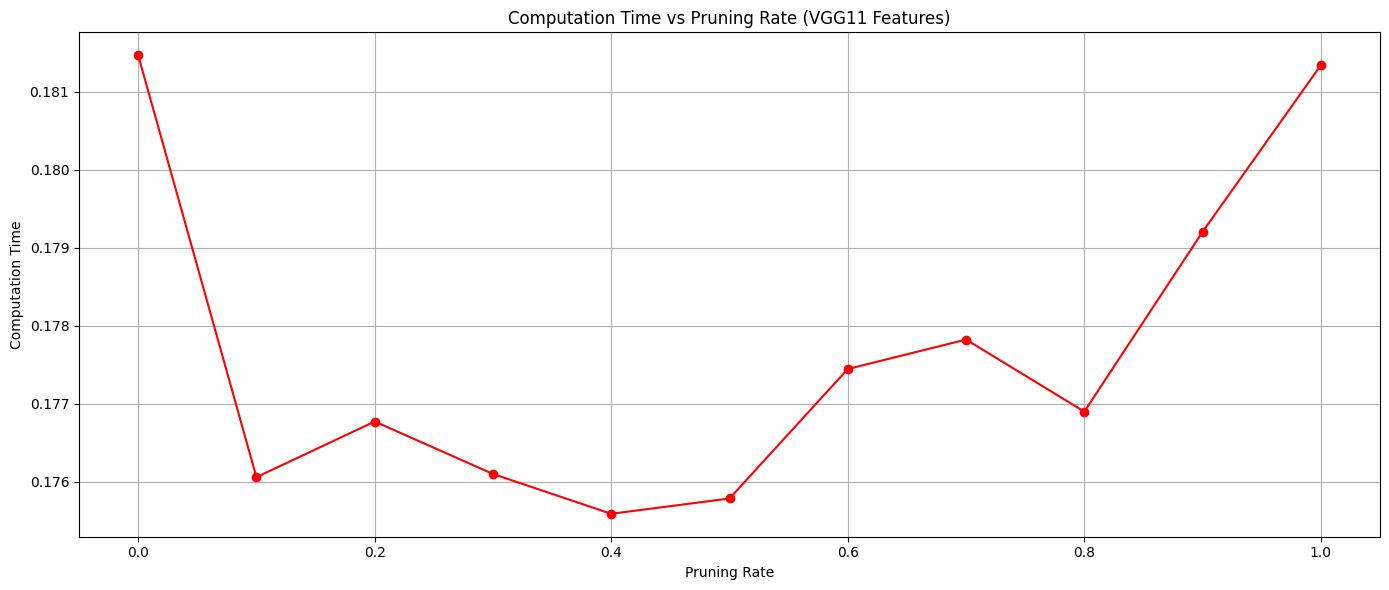

In [9]:
# pruning only vgg11's features
model = models.vgg11()
model = model.to(device)
comp_time = []
for pruning_rate in pruning_rates:
    model = models.vgg11()
    features = model.features
    features = prune_model(features, pruning_rate)
    model.features = features

    model = model.to(device)
    c_time = find_comp_time(model, device)
    comp_time.append(c_time)
    
    print(f"Model: {model.__class__.__name__}, Pruning rate: {pruning_rate:.2f}, Computation time: {c_time:.5f} using {device}")

plt.figure(figsize=(14, 6))
plt.plot(pruning_rates, comp_time, 'ro-')
plt.xlabel('Pruning Rate')
plt.ylabel('Computation Time')
plt.grid(True)
plt.title('Computation Time vs Pruning Rate (VGG11 Features)')
plt.tight_layout()
plt.show()

Model: VGG, Pruning rate: 0.00, Computation time: 0.19007 using mps
Model: VGG, Pruning rate: 0.10, Computation time: 0.19324 using mps
Model: VGG, Pruning rate: 0.20, Computation time: 0.20640 using mps
Model: VGG, Pruning rate: 0.30, Computation time: 0.20724 using mps
Model: VGG, Pruning rate: 0.40, Computation time: 0.20769 using mps
Model: VGG, Pruning rate: 0.50, Computation time: 0.21200 using mps
Model: VGG, Pruning rate: 0.60, Computation time: 0.20571 using mps
Model: VGG, Pruning rate: 0.70, Computation time: 0.20168 using mps
Model: VGG, Pruning rate: 0.80, Computation time: 0.21013 using mps
Model: VGG, Pruning rate: 0.90, Computation time: 0.20425 using mps
Model: VGG, Pruning rate: 1.00, Computation time: 0.19873 using mps


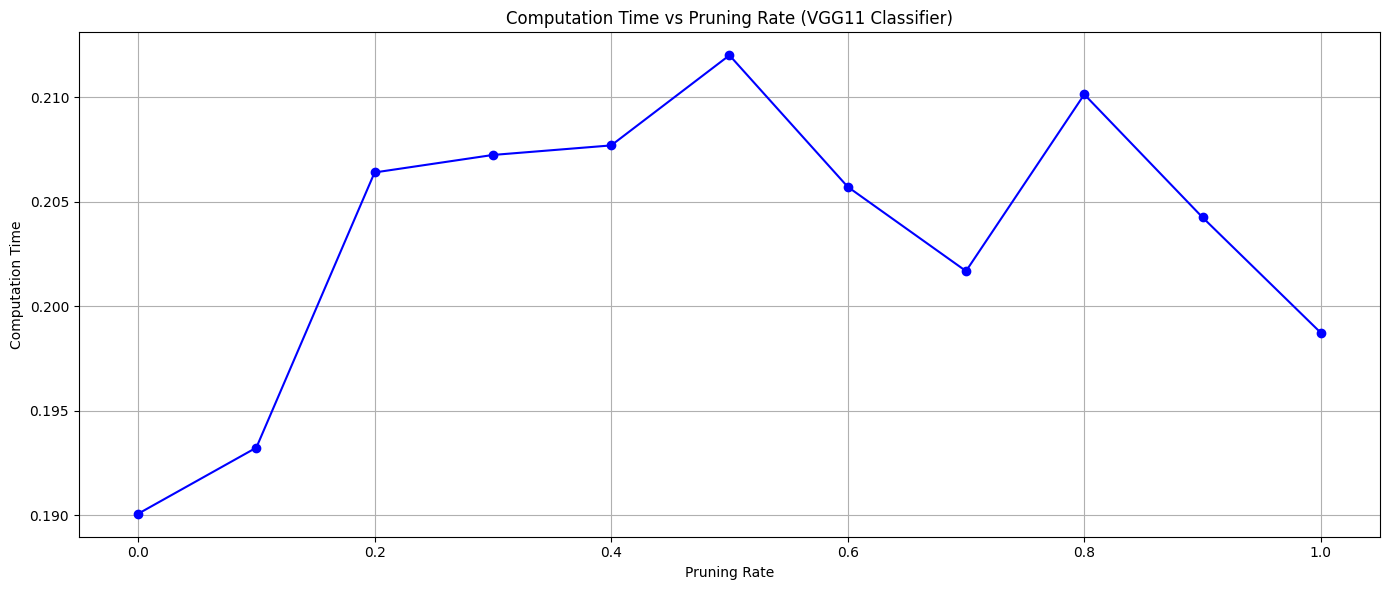

In [10]:
# pruning only vgg11's features
model = models.vgg11()
model = model.to(device)
comp_time = []
for pruning_rate in pruning_rates:
    model = models.vgg11()
    classifier = model.classifier
    classifier = prune_model(classifier, pruning_rate)
    model.classifier = classifier

    model = model.to(device)
    c_time = find_comp_time(model, device)
    comp_time.append(c_time)
    
    print(f"Model: {model.__class__.__name__}, Pruning rate: {pruning_rate:.2f}, Computation time: {c_time:.5f} using {device}")

plt.figure(figsize=(14, 6))
plt.plot(pruning_rates, comp_time, 'bo-')
plt.xlabel('Pruning Rate')
plt.ylabel('Computation Time')
plt.grid(True)
plt.title('Computation Time vs Pruning Rate (VGG11 Classifier)')
plt.tight_layout()
plt.show()